# Аналитика бизнес-показателей Яндекс.Афиши

Цель исследования – отказаться от невыгодных источников трафика и перераспределить бюджет отдела маркетинговой аналитики Яндекс.Афиши. 
Нужно выяснить:
- как клиенты пользуются сервисом; когда делают первые покупки на сайте;
- сколько денег приносит компании каждый клиент;
- когда расходы на привлечение клиента окупаются.

____________________________________________________________________________________________________________________________

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl

<b>1.1 Предобработка visits – лог сервера с данными о посещениях сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.duplicated().sum()

0

Датафрейм содержит 359,4 тысяч строк и 5 столбцов. Дубликатов и пропусков нет. Столбцы End Ts и Start Ts нужно перевести в формат даты.

In [5]:
#изменение названия столбцов

visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
visits = visits.rename(columns = {'End Ts': 'end_ts', 'Source Id':'source_id', 'Start Ts':'start_ts'})

visits.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [7]:
#перевод в формат даты
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

In [8]:
visits['end_ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

In [9]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

Окончание сеанса в датафрейме visits выходит за диапазон с июня 2017 по конец мая 2018 года. Удалим сеансы, которые были после 31 мая 2018 года.

In [10]:
visits = visits.loc[visits['end_ts'] < '2018-06-01']
visits['end_ts'].describe()

count                  359388
unique                 224749
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-05-31 23:59:00
Name: end_ts, dtype: object

<b>1.2 Предобработка orders – выгрузка всех заказов с июня 2017 по конец мая 2018 года

In [11]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [13]:
orders.duplicated().sum()

0

In [14]:
#изменение названия столбцов
orders.columns = ['buy_ts', 'revenue', 'uid']
orders.head(10)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Датафрейм содержит 50,4 тысяч строк и 3 столбца. Дубликатов и пропусков нет. Столбец Buy Ts нужно перевести в формат даты.

In [15]:
#перевод в формат даты
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

In [16]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

В датафрейме содержится информация о заказах с 1 июня 2017 по 1 июня 2018 (время 00:02), однако в описании проекта заявлен диапазон дат с июня 2017 по конец мая 2018. Пусть заказы были всего в течение 2-х минут 1 июня 2018, лучше их убрать.

In [17]:
orders = orders.loc[orders['buy_ts'] < '2018-06-01']
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

<b>1.3 Предобработка costs – статистика рекламных расходов с июня 2017 по конец мая 2018 года

In [18]:
costs = pd.read_csv('/datasets/costs.csv')
costs['costs'].sum()

329131.62

In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [20]:
costs.duplicated().sum()

0

Датафрейм содержит 2,5 тысяч строк и 3 столбца. Дубликатов и пропусков нет. Столбец dt нужно перевести в формат даты.

In [21]:
#перевод в формат даты
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')
costs = costs.rename(columns={'dt':'date'})
costs

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [22]:
costs['date'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: date, dtype: object

<b>2.1. Продуктовые метрики

 - <b>DAU, WAU и MAU. Средние значения этих метрик за весь период.

In [23]:
#Выделим в отдельные столбцы год, месяц, неделю и полную дату
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [24]:
#Рассчитаем DAU, WAU и MAU
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()

wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)

mau_total = (
    visits.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    .mean()
)

In [25]:
dau_total.round()

uid    908.0
dtype: float64

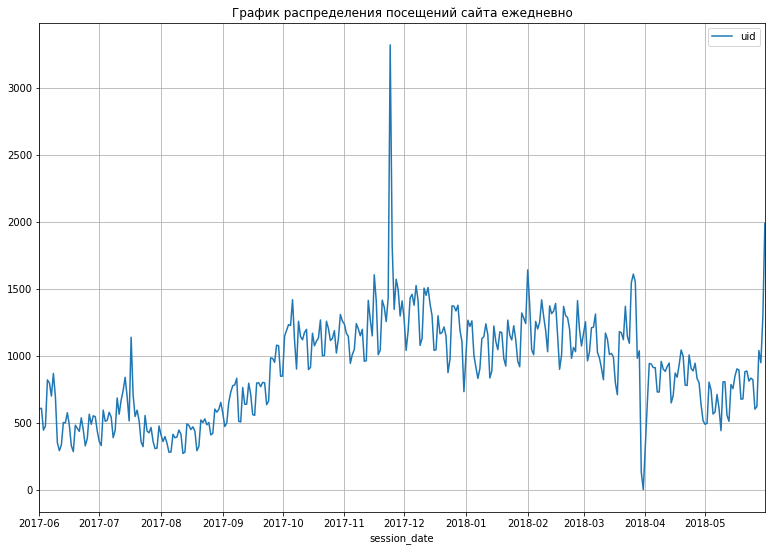

In [26]:
dau_distribution = visits.groupby('session_date').agg({'uid': 'nunique'})
dau_distribution.plot(grid=True, title='График распределения посещений сайта ежедневно', figsize=(13, 9))

In [27]:
dau_distribution['uid'].describe()

count     364.000000
mean      907.967033
std       370.441259
min         1.000000
25%       594.000000
50%       921.000000
75%      1173.000000
max      3319.000000
Name: uid, dtype: float64

In [28]:
dau_distribution.loc[dau_distribution['uid'].isin(['1'])]

,uid
session_date,
2018-03-31,1


In [29]:
dau_distribution.loc[dau_distribution['uid'].isin(['3319'])]

,uid
session_date,
2017-11-24,3319


Среднее количество уникальных посетителей сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года в день – 908 человек. <bR>На графике есть выбросы: 24 ноября 2017 на сайт зашло 3319 посетителей, а 31 марта 2018 – всего 1 человек. С октября 2017 по апрель 2018 ежедевное количество посетителей варьируется между 1000 и 1500 человек в день. В последние дни мая 2018 есть резкий скачок по количеству уникальных посетителей в день.

In [30]:
wau_total.round()

uid    5716.0
dtype: float64

In [31]:
wau_distribution = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
wau_distribution.head()

uid
session_year session_week      
2017         22            2021
             23            4129
             24            2812
             25            2878
             26            3064

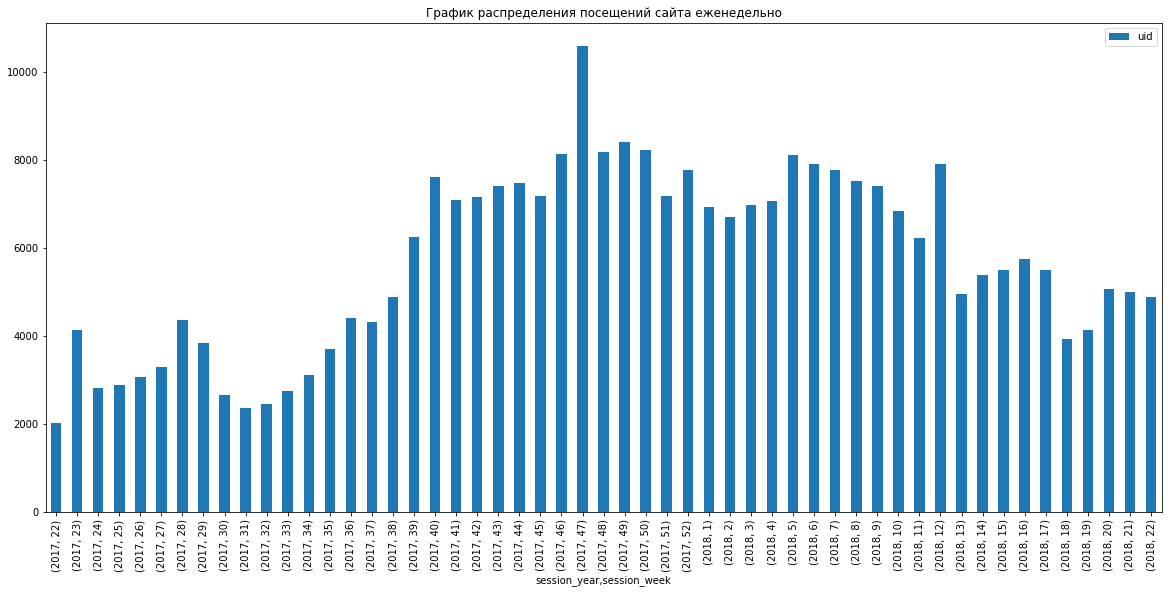

In [32]:
wau_distribution.plot(kind='bar', title='График распределения посещений сайта еженедельно', figsize=(20, 9))

In [33]:
wau_distribution['uid'].describe()

count       53.00000
mean      5716.09434
std       2049.96018
min       2021.00000
25%       4128.00000
50%       5740.00000
75%       7401.00000
max      10586.00000
Name: uid, dtype: float64

In [34]:
wau_distribution.loc[wau_distribution['uid'].isin(['10586'])]

,,uid
session_year,session_week,
2017,47,10586


Среднее количество уникальных посетителей сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года в неделю – 5 716 человек. С 32 недели 2017 года в целом количество посетителей в неделю растет, достигнув максимума на 47 неделе 2017 года. С тех пор количество уникальных посетителей понемногу снижается.

In [35]:
mau_total.round()

uid    23228.0
dtype: float64

In [36]:
mau_distribution = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
mau_distribution

uid
session_year session_month       
2017         6              13259
             7              14183
             8              11631
             9              18975
             10             29692
             11             32797
             12             31557
2018         1              28716
             2              28749
             3              27473
             4              21008
             5              20694

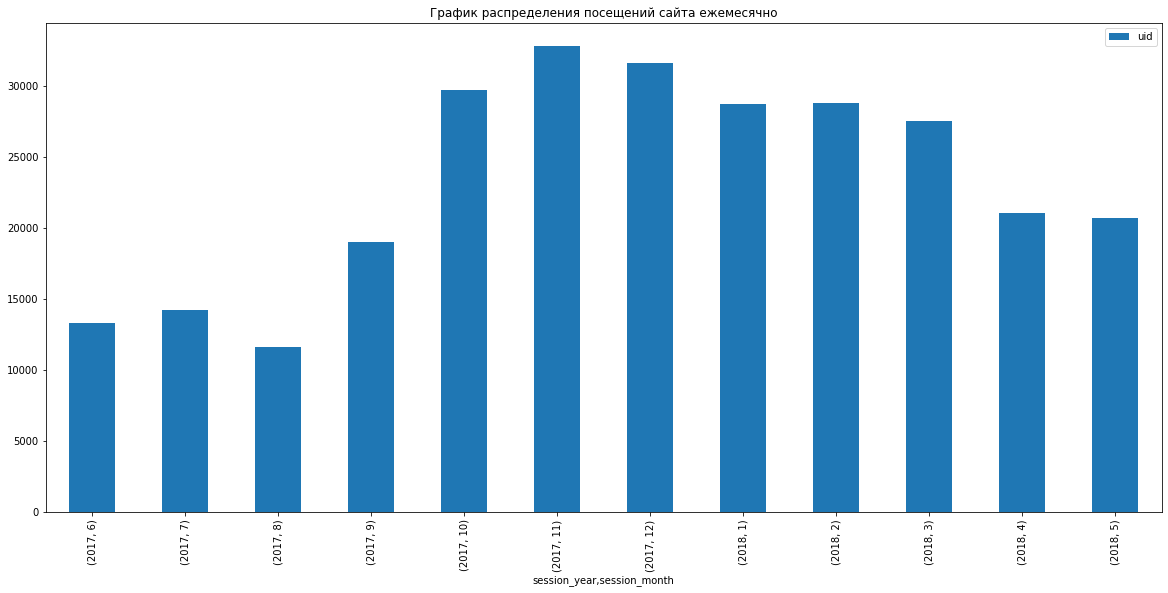

In [37]:
mau_distribution.plot(kind='bar', title='График распределения посещений сайта ежемесячно', figsize=(20, 9))

Среднее количество уникальных посетителей сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года в месяц – 23 228 человек. C августа 2017 года количество пользователей в мемсяц растет вплоть до ноября 2017 года. Затем количество уникальных посетителей в месяц снижается.

____________________________________________________________________________________________________________________________

 - <b>Среднее количество посещений пользователей за день.

In [38]:
session_date_count = visits.groupby('session_date').agg({'uid': 'count'}).mean()
session_date_count.round()

uid    987.0
dtype: float64

In [39]:
sessions_count = visits.groupby('session_date').agg({'uid': 'count'})
sessions_count = sessions_count.rename(columns = {'uid': 'views'})
sessions_uniq = visits.groupby('session_date').agg({'uid': 'nunique'})
sessions_by_user = pd.merge(sessions_count, sessions_uniq, on='session_date')
sessions_by_user['sessions_by_user'] = (sessions_by_user['views'] / sessions_by_user['uid']).round(2)

sessions_by_user

,views,uid,sessions_by_user
session_date,,,
2017-06-01,664,605,1.10
2017-06-02,658,608,1.08
2017-06-03,477,445,1.07
2017-06-04,510,476,1.07
2017-06-05,893,820,1.09
...,...,...,...
2018-05-27,672,620,1.08
2018-05-28,1156,1039,1.11
2018-05-29,1035,948,1.09


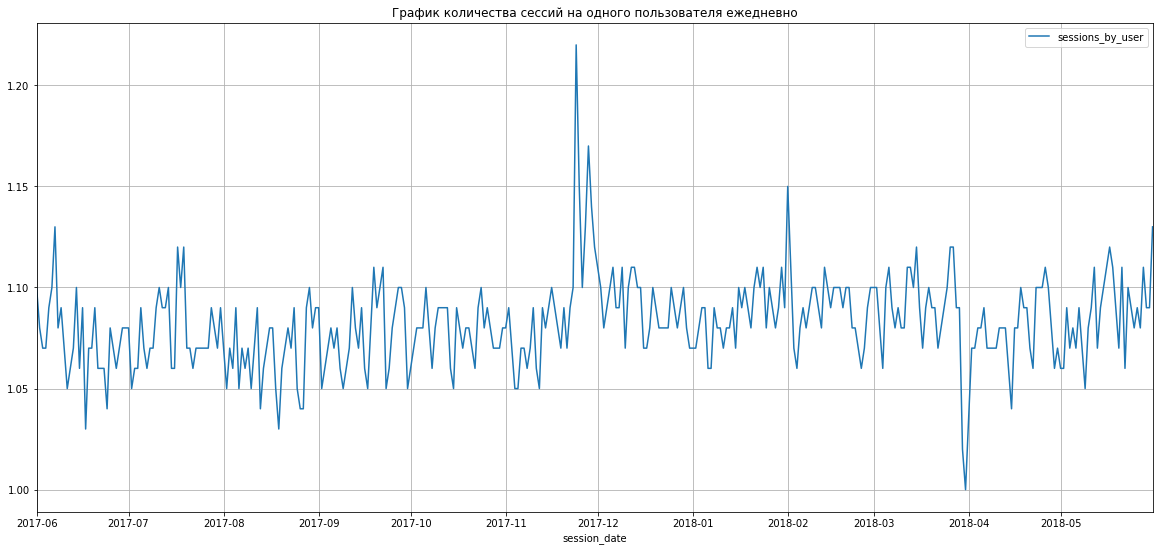

In [40]:
sessions_by_user = sessions_by_user.groupby('session_date').agg({'sessions_by_user': 'sum'})
sessions_by_user.plot(grid=True, title='График количества сессий на одного пользователя ежедневно', figsize=(20, 9))

In [41]:
sessions_by_user.mean()

sessions_by_user    1.08239
dtype: float64

Пользователи в среднем посещают сайт Яндекс.Афиши 987 раз в день. В среднем каждый посетитель заходит на сайт 1,08 раз. На графике виден пик во второй половине ноября 2017 года, а также провал в конце марта 2018 года, ровно как и на графиках выше. 

____________________________________________________________________________________________________________________________

 - <b> Среднее количество времени, которое пользователи проводят на сайте. 

Text(0, 0.5, 'Value')

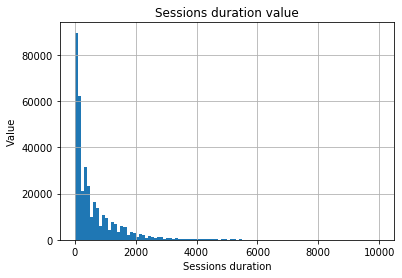

In [42]:
#продолжительность сессии
visits['session_duration_sec'] =(
    visits['end_ts'] - visits['start_ts']
).dt.seconds

visits['session_duration_sec'].hist(bins=100, range=(0, 10000))
pl.title("Sessions duration value")
pl.xlabel("Sessions duration")
pl.ylabel("Value")

In [43]:
visits['session_duration_sec'].describe()

count    359388.000000
mean        643.465703
std        1016.280993
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [44]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

<div class="alert alert-info"> <b>Комментарий студента:</b> Немного изменила график, добавила оси и название</div>

На гистограмме длина сессии распределена неравномерно, поэтому смотрим на моду – значение в выборке, которое встречается чаще всего. В среднем посетители находятся на сайте 60 секунд.

In [45]:
device = visits.groupby('device').agg({'uid': 'nunique'})
device['percentage'] = (device['uid'] / device['uid'].sum())*100
device['percentage'] = device['percentage'].round()
device

,uid,percentage
device,,
desktop,164517,70.0
touch,71343,30.0


Большая часть посетителей заходят на сайт с компьютера и только 30% – через мобильные телефоны.

____________________________________________________________________________________________________________________________

 - <b>Retention Rate

In [46]:
#запишем данные о первых действиях посетителей на сайте в объект Series и объединим его с visits_new
visits_new = visits[['session_date', 'uid']]
first_activity_date = visits_new.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits_new = visits_new.join(first_activity_date,on='uid')

In [47]:
#Выделим месяц когорты
visits_new['first_order_month'] = visits_new['first_activity_date'].astype('datetime64[M]')
visits_new['order_month'] = visits_new['session_date'].astype('datetime64[M]')

In [48]:
#Определим продолжительность жизни пользователя в рамках когорты
visits_new['cohort_lifetime'] = visits_new['order_month'] - visits_new['first_order_month']
visits_new['cohort_lifetime'] = visits_new['cohort_lifetime']/ np.timedelta64(1,'M')
visits_new['cohort_lifetime'] = visits_new['cohort_lifetime'].round().astype('int')

In [49]:
#Сгруппируем данные по когорте и продолжительности жизни пользователя
cohorts = visits_new.groupby(['first_order_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

#Исходное количество пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_order_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count, on='first_order_month')

In [50]:
#Расчет retention rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

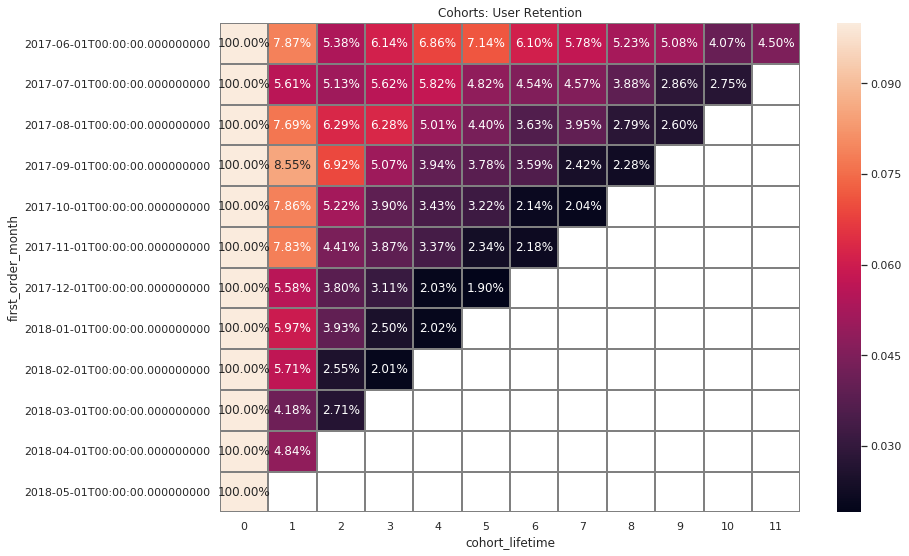

In [51]:
#Построение тепловой карты
retention_pivot = cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmax = 0.1);

In [52]:
#Средний Retention Rate на второй месяц «жизни» когорт
(retention_pivot[1].mean()*100).round(2)

6.52

Очень низкое значение возвращаемости клиентов. Вероятно посетители возвращаются к сервису, когда намериваются посетить конкретное мероприятие, а не заходят на сайт для выбора, чем бы заняться в ближайшее время. Средний процент возвращаемости на 2 месяц жизни когорт – 6,52%. 

____________________________________________________________________________________________________________________________

<b>2.2. Метрики электронной коммерции

 - <b> Среднее количество времени с момента первого посещения сайта до совершения покупки. 

In [53]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                .rename(columns={'start_ts':'first_visit_date'})\
                .reset_index()
first_visit

,uid,first_visit_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228157,18446403737806311543,2017-11-30 03:36:00
228158,18446424184725333426,2017-12-06 20:32:00
228159,18446556406699109058,2018-01-01 16:29:00
228160,18446621818809592527,2017-12-27 13:27:00


In [54]:
first_order = orders.groupby('uid').agg({'buy_ts':'min'})\
                .rename(columns={'buy_ts':'first_buy_date'})\
                .reset_index()
first_order

,uid,first_buy_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36517,18445147675727495770,2017-11-24 09:03:00
36518,18445407535914413204,2017-09-22 23:55:00
36519,18445601152732270159,2018-03-26 22:54:00
36520,18446156210226471712,2018-02-18 19:34:00


In [55]:
buying_time = first_visit.merge(first_order, on='uid', how='inner')
buying_time

,uid,first_visit_date,first_buy_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36517,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
36518,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
36519,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00
36520,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00


In [56]:
buying_time['buying_time'] = (buying_time['first_buy_date'] - buying_time['first_visit_date'])
buying_time['buying_time'].dt.days

buying_time['buying_time'].describe()

count                      36522
mean     16 days 21:40:50.532281
std      47 days 01:45:34.984683
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:30
max            363 days 07:04:00
Name: buying_time, dtype: object

Text(0, 0.5, 'Value')

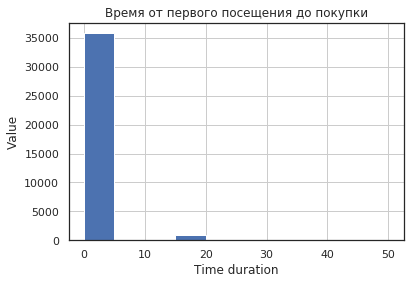

In [57]:
#гистограмма времени от первого посещения до покупки
visits['session_duration_sec'].hist(bins=10, range=(0,50))
pl.title("Время от первого посещения до покупки")
pl.xlabel("Time duration")
pl.ylabel("Value")

In [58]:
buying_time['buying_time'].mode()

0   00:01:00
dtype: timedelta64[ns]

Поскольку на гистограмме ненормальное распределение, среднее время от первого посещения до покупки смотрим по моде. Получается, что в среднем требуется 1 минута на покупку. Ровно столько же равно среднее время сеанса. Значит посетители приходят на сайт за конкретным продуктом и сразу же его приобретают без лишних размышлений.

____________________________________________________________________________________________________________________________

 - <b>Среднее количество покупок на одного покупателя за 6 месяцев.

In [59]:
#внесем данные о первых покупках посетителей в объект Series и объединим его с orders
first_orders = orders.groupby('uid')['buy_ts'].min()
first_orders.name = 'first_buy_date' 
orders = orders.join(first_orders, on = 'uid').reset_index()
orders

,index,buy_ts,revenue,uid,first_buy_date
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
...,...,...,...,...,...
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-31 23:43:00
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00


In [60]:
#выделим время от первой покупки до последующей
orders['time'] = (orders['buy_ts'] - orders['first_buy_date']) / np.timedelta64(1,'M')
orders['time'] = orders['time'].astype('int')
orders['time'].describe()

count    50414.000000
mean         0.537549
std          1.612714
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: time, dtype: float64

In [61]:
#Покупки в течение 6 месяцев
orders['first_buy_date'] = orders['first_buy_date'].astype('datetime64[M]')
orders_6_months = orders[orders['time'] <= 5]
orders_6_months

,index,buy_ts,revenue,uid,first_buy_date,time
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0
...,...,...,...,...,...,...
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,0
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,0
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,0
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,0


In [62]:
#сгруппируем когорту
cohort_grouped = orders_6_months.groupby(['first_buy_date', 'time']).agg({'uid' : 'nunique', 'revenue' : 'count'}).reset_index()
cohort_grouped.head()

,first_buy_date,time,uid,revenue
0,2017-06-01,0,2023,2417
1,2017-06-01,1,46,155
2,2017-06-01,2,48,171
3,2017-06-01,3,75,276
4,2017-06-01,4,78,263


In [63]:
#среднее количество покупок на одного пользователя
cohort_grouped['purchase_per_user'] = (cohort_grouped['revenue'] / cohort_grouped['uid'])
cohort_grouped.head()

,first_buy_date,time,uid,revenue,purchase_per_user
0,2017-06-01,0,2023,2417,1.194760
1,2017-06-01,1,46,155,3.369565
2,2017-06-01,2,48,171,3.562500
3,2017-06-01,3,75,276,3.680000
4,2017-06-01,4,78,263,3.371795


In [64]:
output = cohort_grouped.pivot_table(index = 'first_buy_date', columns = 'time', values = 'purchase_per_user', aggfunc = 'mean')
output.round(3).fillna('')

time,0,1,2,3,4,5
first_buy_date,,,,,,
2017-06-01,1.195,3.37,3.562,3.68,3.372,3.948
2017-07-01,1.165,1.685,2.016,1.49,1.522,2.118
2017-08-01,1.175,1.961,1.66,2.167,1.892,1.824
2017-09-01,1.194,1.681,2.069,1.745,1.571,1.549
2017-10-01,1.187,1.396,1.309,1.451,1.241,1.439
2017-11-01,1.253,1.526,1.838,1.784,1.193,1.238
2017-12-01,1.183,1.858,2.179,1.828,1.979,1.425
2018-01-01,1.169,1.977,1.74,1.551,1.526,
2018-02-01,1.162,1.932,1.362,1.65,,


Text(0, 0.5, 'Value')

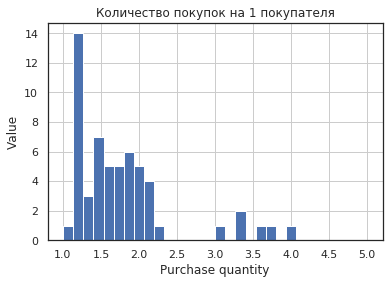

In [65]:
cohort_grouped['purchase_per_user'].hist(bins=30, range=(1, 5))
pl.title("Количество покупок на 1 покупателя")
pl.xlabel("Purchase quantity")
pl.ylabel("Value")

In [66]:
cohort_grouped['purchase_per_user'].mean().round(3)

1.787

В среднем каждый покупатель совершает 1.79 покупки в течение 6 месяцев. 

____________________________________________________________________________________________________________________________

 - <b>Средний чек.

In [67]:
#общий средний чек за весь период
orders['revenue'].mean()

4.9996782639742925

In [68]:
orders['first_order_month'] = orders['first_buy_date'].astype('datetime64[M]')
orders

,index,buy_ts,revenue,uid,first_buy_date,time,first_order_month
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0,2017-06-01
...,...,...,...,...,...,...,...
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,0,2018-05-01
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,0,2018-05-01
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,0,2018-05-01
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,0,2018-05-01


In [69]:
cohort_avg_check = orders.groupby(['first_order_month', 'time']).agg({'uid' : 'nunique', 'revenue' : 'mean'}).reset_index()
cohort_avg_check.rename(columns = {'revenue':'avg_check'}, inplace = True)
cohort_avg_check.head()

,first_order_month,time,uid,avg_check
0,2017-06-01,0,2023,4.115449
1,2017-06-01,1,46,5.283355
2,2017-06-01,2,48,5.607544
3,2017-06-01,3,75,8.639094
4,2017-06-01,4,78,6.197034


In [70]:
#количество покупателей в каждой когорте
users_by_first_order_month = orders.pivot_table(
    index='first_order_month', values='uid', aggfunc='count').sort_values(by='first_order_month', ascending=True)
users_by_first_order_month

,uid
first_order_month,
2017-06-01,4438
2017-07-01,2910
2017-08-01,2188
2017-09-01,3878
2017-10-01,6005
2017-11-01,5900
2017-12-01,5894
2018-01-01,4308
2018-02-01,4470


In [71]:
#средний чек каждой когорты
avg_check_by_first_order_month = orders.pivot_table(
    index='first_order_month', values='revenue', aggfunc='mean').sort_values(by='first_order_month', ascending=True)
avg_check_by_first_order_month

,revenue
first_order_month,
2017-06-01,5.414982
2017-07-01,5.542241
2017-08-01,5.304506
2017-09-01,8.941805
2017-10-01,4.596744
2017-11-01,4.423558
2017-12-01,5.681327
2018-01-01,3.867950
2018-02-01,3.747315


In [72]:
avg_check =(cohort_avg_check
            .pivot_table(index='first_order_month',
                        columns = 'time',
                        values = 'avg_check',
                        aggfunc = 'sum')
            .reset_index())

avg_check.round(2).fillna('')

time,first_order_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,4.12,5.28,5.61,8.64,6.2,8.4,5.57,7.01,5.19,9.35,11.58,5.91
1,2017-07-01,5.32,6.62,10.35,4.45,4.79,3.73,3.76,6.43,4.42,11.27,5.77,
2,2017-08-01,4.77,6.08,7.48,7.28,7.03,5.62,5.18,9.54,5.52,9.28,,
3,2017-09-01,5.29,12.85,52.66,22.42,17.12,12.73,13.5,7.92,10.28,,,
4,2017-10-01,4.50,6.12,5.18,5.74,4.83,4.14,4.96,3.5,,,,
5,2017-11-01,4.31,4.96,5.43,6.21,3.76,3.69,5.22,,,,,
6,2017-12-01,4.11,7.41,25.47,21.16,26.85,3.52,,,,,,
7,2018-01-01,3.74,5.02,8.57,2.96,3.02,,,,,,,
8,2018-02-01,3.74,3.89,3.82,3.78,,,,,,,,
9,2018-03-01,4.23,4.45,7.5,,,,,,,,,


Text(0, 0.5, 'Value')

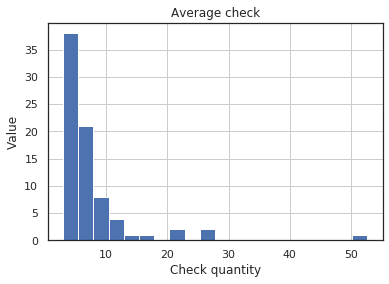

In [73]:
cohort_avg_check['avg_check'].hist(bins=20)
pl.title("Average check")
pl.xlabel("Check quantity")
pl.ylabel("Value")

In [74]:
orders['purchase_day'] = orders['buy_ts'].dt.date
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders

,index,buy_ts,revenue,uid,first_buy_date,time,first_order_month,purchase_day,purchase_month
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01


In [75]:
#средний чек по месяцам
avg_check_per_month = orders.groupby(['purchase_month']).agg({'uid' : 'nunique', 'revenue' : 'mean'}).reset_index()
avg_check_per_month.rename(columns = {'revenue':'avg_check'}, inplace = True)
avg_check_per_month

,purchase_month,uid,avg_check
0,2017-06-01,2023,4.060106
1,2017-07-01,1984,5.306589
2,2017-08-01,1472,4.847139
3,2017-09-01,2750,5.416448
4,2017-10-01,4675,4.928280
5,2017-11-01,4547,4.783518
6,2017-12-01,4942,5.852139
7,2018-01-01,3898,4.112927
8,2018-02-01,4258,4.840095
9,2018-03-01,4181,5.413930


Text(0, 0.5, 'Value')

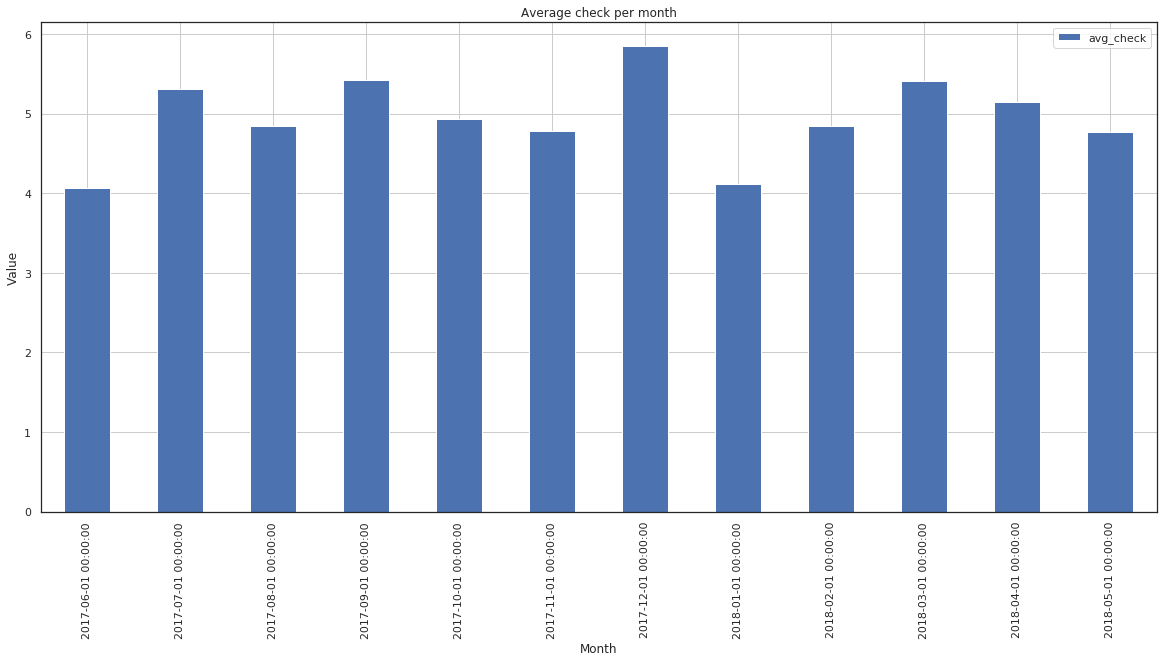

In [76]:
avg_check_per_month = avg_check_per_month.groupby('purchase_month').agg({'avg_check': 'sum'})
avg_check_per_month.plot(kind='bar', grid=True, title='Средний чек по месяцам', figsize=(20, 9))
pl.title("Average check per month")
pl.xlabel("Month")
pl.ylabel("Value")


Средний чек составляет 4.99 у.е. В целом средний чек покупателя в каждом последующим месяце растет. Особо выделяются покупатели, совершившие первую покупку в сентябре 2017 года, – через 2 месяца после первой покупки их средний чек составил 52.66 у.е. Видимо в ноябре 2017 им были предложены специальные предложения или скидки. Покупателям, совершившим первую покупку в декабре 2017 года, судя по всему тоже предложили спец. предложения с февраля по апрель 2018 года – их средний чек в этот период составил от 21,16 от 26,85 у.е.

Самый большой средний чек был в декабре 2017. Перед Новым годом увеличивается спрос на покупку продукта в качестве подарка, также с конца ноября начинается Черная пятница и череда скидок.. Поэтому средний чек мог вырасти. А также на фоне такого спроса вероятно была повышена цена, что также могло повлиять на средний чек.

____________________________________________________________________________________________________________________________

 - <b>LTV на покупателя по когортам.

In [77]:
orders['buy_ts'].describe() 

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

In [78]:
costs['date'].describe() 

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: date, dtype: object

Даты первой покупки и расходов совпадают. Однако последняя покупка была 1 июля 2018, а расходы –  31 мая 2018. Уберем данные за 1 июля 2018 в датафрейме orders. Далее выделим месяцы из дат в таблицах с покупками и расходами.

In [79]:
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

In [80]:
orders.tail()

,index,buy_ts,revenue,uid,first_buy_date,time,first_order_month,purchase_day,purchase_month
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01
50413,50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01


In [81]:
costs['month'] = costs['date'].astype('datetime64[M]') 
costs

,source_id,date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [82]:
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders['first_order_month'] = first_orders['buy_ts'].astype('datetime64[M]') 
first_orders.drop(first_orders.columns[1], axis = 1, inplace = True) 
first_orders

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01
...,...,...
36517,18445147675727495770,2017-11-01
36518,18445407535914413204,2017-09-01
36519,18445601152732270159,2018-03-01
36520,18446156210226471712,2018-02-01


In [83]:
#количество новых покупателей за каждый месяц
cohort_sizes_ltv = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes_ltv.columns = ['first_order_month', 'n_buyers']
cohort_sizes_ltv

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [84]:
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new

,index,buy_ts,revenue,uid,first_buy_date,time,first_order_month_x,purchase_day,purchase_month,first_order_month_y
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,0,2017-06-01,2017-06-01,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...,...
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01,2018-05-01
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01,2018-05-01
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01,2018-05-01
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,0,2018-05-01,2018-05-31,2018-05-01,2018-05-01


In [85]:
orders_new = pd.DataFrame(orders_new) 
orders_new.drop(orders_new.columns[[4,5,7]], axis = 1, inplace = True) 
orders_new.rename(columns = {'first_order_month_x':'first_order_month'}, inplace = True) 
orders_new['order_month'] = orders_new['buy_ts'].astype('datetime64[M]')
orders_new

,index,buy_ts,revenue,uid,first_order_month,purchase_month,first_order_month_y,order_month
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...
50409,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,2018-05-01,2018-05-01,2018-05-01
50410,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01,2018-05-01,2018-05-01
50411,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01,2018-05-01,2018-05-01
50412,50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01,2018-05-01,2018-05-01


In [86]:
cohorts_ltv = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts_ltv

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
73,2018-03-01,2018-04-01,1063.05
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92


In [87]:
report = pd.merge(cohort_sizes_ltv, cohorts_ltv, on='first_order_month')
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92


In [88]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4
...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1


In [89]:
report['ltv'] = report['gp'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599


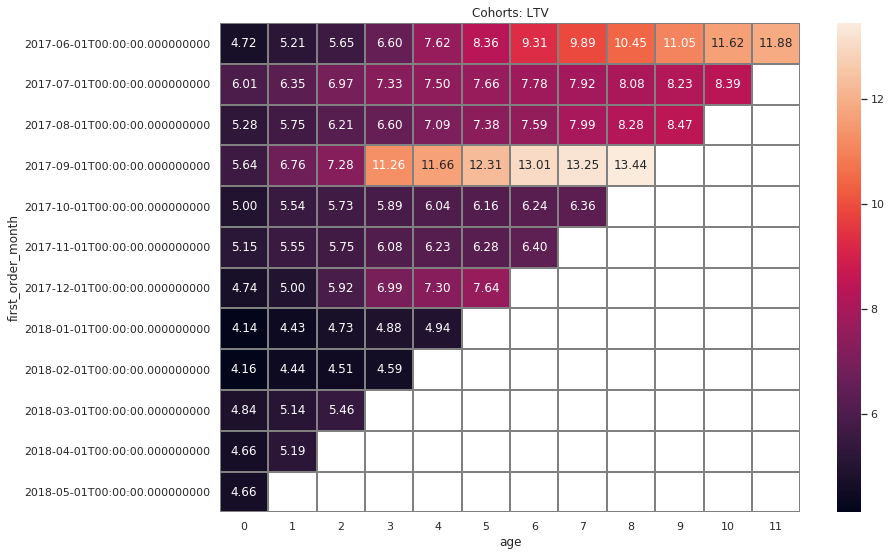

In [90]:
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)
output

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV')
sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

In [91]:
m6_cum_ltv = output.cumsum(axis=1).mean(axis=0)[5]
m6_cum_ltv.round(2)

7.97

Cредний LTV по когортам за 6 месяцев – 7.97 у.е. Самую большую сумму покупатели тратят в первый месяц пользования с сервисом. Пользователи, совершившие первую покупку в сентябре 2017, принесли больше выручки. На четвертый месяц покупок у этой кагорты есть скачок в LTV. Стоит посмотреть, как привлекли эту когорту на повторную покупку.

____________________________________________________________________________________________________________________________

<b>2.3. Маркетинговые метрики</b><bR>

Посчитайте и отобразите на графиках, как маркетинговые метрики различаются по рекламным источникам.
Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. Например, главным может стать первый источник перехода.

 - <b>Общая сумма расходов на маркетинг по источникам.

In [92]:
costs['costs'].sum()

329131.62

In [93]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source['percentage'] = costs_by_source['costs'] / costs_by_source['costs'].sum() * 100
costs_by_source.sort_values('percentage', ascending = False)

,source_id,costs,percentage
2,3,141321.63,42.937725
3,4,61073.60,18.555981
4,5,51757.10,15.725350
1,2,42806.04,13.005751
0,1,20833.27,6.329769
6,10,5822.49,1.769046
5,9,5517.49,1.676378


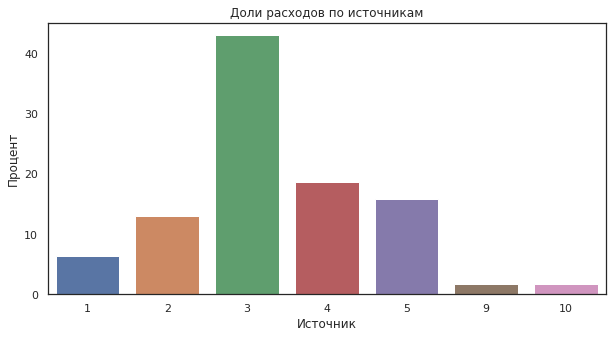

In [94]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x="source_id", y="percentage", data=costs_by_source)
plt.title('Доли расходов по источникам')
ax.set_xlabel('Источник')
ax.set_ylabel('Процент')
plt.show()

Всего на маркетинг потрачено 329 131.62 у.е., большую часть из которых выделено на источник 3 – 43%. На источники 10 и 9 выделено меньше всего – 1,8% и 1,7% соответственно.

In [95]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

В датафрейме costs отсутствуют расходы по источникам 6 и 7, информация о которых есть в датафрейме visits. Значит клиенты привлекались без сторонних затрат, например, с помощью размещения информации о продукте на сайтах и площадках партнеров на безвозмездной основе или покупатели переходили на сервис через поисковые сервисы Google или Яндекс. 

____________________________________________________________________________________________________________________________

 - <b>Средний CAC на одного покупателя для всего проекта и для каждого источника трафика.

In [96]:
len(orders['uid'].unique())

36522

In [97]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_source.reset_index()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [98]:
len(visits['uid'].unique())

228162

In [99]:
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [100]:
visits = pd.merge(visits, first_visit, on='uid')
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:05:00
...,...,...,...,...,...,...,...,...,...,...,...
359383,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017,11,45,2017-11-08,0,2017-11-08 13:39:00
359384,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017,7,31,2017-07-31,1080,2017-07-31 12:13:00
359385,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018,3,12,2018-03-20,840,2018-03-20 15:11:00
359386,touch,2018-04-03 11:23:00,5,2018-04-03 11:19:00,3266363999948772866,2018,4,14,2018-04-03,240,2018-04-03 11:19:00


In [101]:
visits_by_source = visits.query('start_ts == first_visit')
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})

customers_by_source.reset_index()

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10295
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [102]:
cac = customers_by_source.join(costs_by_source).reset_index()
cac

,source_id,customers,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10295,61073.60
4,5,6931,51757.10
5,7,1,NaN
6,9,1088,5517.49
7,10,1329,5822.49


In [103]:
cac['cac'] = cac['costs'] / cac['customers']
cac['cac'] = cac['cac'].round()
cac.sort_values('cac', ascending = False)

,source_id,customers,costs,cac
2,3,10473,141321.63,13.0
1,2,3506,42806.04,12.0
0,1,2899,20833.27,7.0
4,5,6931,51757.10,7.0
3,4,10295,61073.60,6.0
6,9,1088,5517.49,5.0
7,10,1329,5822.49,4.0
5,7,1,NaN,NaN


In [104]:
cac.fillna(0, inplace=True)
cac

,source_id,customers,costs,cac
0,1,2899,20833.27,7.0
1,2,3506,42806.04,12.0
2,3,10473,141321.63,13.0
3,4,10295,61073.60,6.0
4,5,6931,51757.10,7.0
5,7,1,0.00,0.0
6,9,1088,5517.49,5.0
7,10,1329,5822.49,4.0


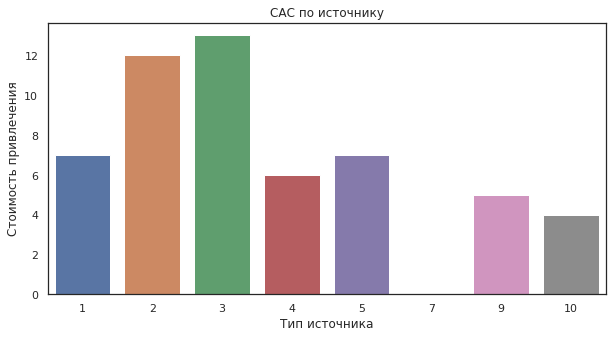

In [105]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

In [106]:
cac_total = cac['costs'].sum() / cac['customers'].sum()
cac_total.round(3)

9.012

Средний CAC на одного покупателя для всего проекта составляет 9.012 у.е. Самая большая стоимость привлечения клиентов у 3 источника, он же приносит большее количество клиентов.

In [107]:
customers_source_by_month = visits_by_source.merge(orders, on='uid')
customers_source_by_month.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit,index,buy_ts,revenue,first_buy_date,time,first_order_month,purchase_day,purchase_month
0,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:05:00,39201,2018-03-09 20:25:00,2.33,2018-03-01,0,2018-03-01,2018-03-09,2018-03-01
1,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03 21:35:00,6788,2017-09-04 12:46:00,2.44,2017-09-01,0,2017-09-01,2017-09-04,2017-09-01
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03 21:35:00,14979,2017-10-28 00:01:00,1.53,2017-09-01,1,2017-09-01,2017-10-28,2017-10-01
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60,2017-09-03 21:35:00,15068,2017-10-28 19:16:00,1.53,2017-09-01,1,2017-09-01,2017-10-28,2017-10-01
4,desktop,2017-06-04 14:21:00,2,2017-06-04 14:17:00,8056418121947262981,2017,6,22,2017-06-04,240,2017-06-04 14:17:00,1945,2017-06-25 08:54:00,3.67,2017-06-01,0,2017-06-01,2017-06-25,2017-06-01


In [108]:
customers_source_by_month = customers_source_by_month[['first_visit','source_id', 'uid']].sort_values(by='first_visit', ascending=False)
customers_source_by_month['first_visit'] = customers_source_by_month['first_visit'].astype('datetime64[M]')
customers_source_by_month.reset_index().head()

,index,first_visit,source_id,uid
0,32400,2018-05-01,3,1786462140797698849
1,45636,2018-05-01,10,15576344609395725707
2,45221,2018-05-01,3,1551265230644458155
3,48782,2018-05-01,4,15854392578508828030
4,31237,2018-05-01,10,11369640365507475976


In [109]:
source_data = customers_source_by_month.groupby(['first_visit','source_id']).agg({'uid':'nunique'}).reset_index()
source_data = source_data.rename(columns = {'first_visit': 'month'})
source_data.head()

,month,source_id,uid
0,2017-06-01,1,240
1,2017-06-01,2,374
2,2017-06-01,3,886
3,2017-06-01,4,647
4,2017-06-01,5,509


In [110]:
costs_source = costs.groupby(['month','source_id']).agg({'costs':'sum'}).reset_index()

In [111]:
source_grouped = source_data.merge(costs_source, on=['month', 'source_id'], how='left')
source_grouped.head()

,month,source_id,uid,costs
0,2017-06-01,1,240,1125.61
1,2017-06-01,2,374,2427.38
2,2017-06-01,3,886,7731.65
3,2017-06-01,4,647,3514.80
4,2017-06-01,5,509,2616.12


In [112]:
source_grouped['costs'].sum()

329131.62

In [113]:
costs['costs'].sum()

329131.62

In [114]:
source_grouped['cac'] = source_grouped['costs'] / source_grouped['uid']
source_grouped

,month,source_id,uid,costs,cac
0,2017-06-01,1,240,1125.61,4.690042
1,2017-06-01,2,374,2427.38,6.490321
2,2017-06-01,3,886,7731.65,8.726467
3,2017-06-01,4,647,3514.80,5.432457
4,2017-06-01,5,509,2616.12,5.139725
...,...,...,...,...,...
80,2018-05-01,3,624,9411.42,15.082404
81,2018-05-01,4,610,4214.21,6.908541
82,2018-05-01,5,406,3669.56,9.038325
83,2018-05-01,9,30,362.17,12.072333


In [115]:
#Общий CAC по источникам
total_cac_by_source = source_grouped.groupby(['source_id']).agg({'uid':'sum','costs':'sum'}).reset_index()
total_cac_by_source['cac'] = (total_cac_by_source['costs'] / total_cac_by_source['uid']).round(2)
total_cac_by_source.sort_values('cac', ascending=False)

,source_id,uid,costs,cac
2,3,10473,141321.63,13.49
1,2,3506,42806.04,12.21
4,5,6931,51757.10,7.47
0,1,2899,20833.27,7.19
3,4,10295,61073.60,5.93
6,9,1088,5517.49,5.07
7,10,1329,5822.49,4.38
5,7,1,0.00,0.00


In [116]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [117]:
#Общий CAC по сервису
CAC = (total_cac_by_source['costs'].sum() / total_cac_by_source['uid'].sum()).round(2)
CAC

9.01

Самый большая стоимость привлечения клиента у источника 3 и 2. С источника 7 пришел всего 1 покупатель без затрат, а по 6 источнику не было ни затрат, ни покупателей.

In [118]:
#cac источников в динамике
output_cac_source = source_grouped.pivot_table(
    index='month', columns='source_id', values='cac', aggfunc='mean'
)

output_cac_source.round(2)

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,4.69,6.49,8.73,5.43,5.14,1.85,2.78
2017-07-01,5.83,8.39,11.54,5.24,6.04,3.03,5.41
2017-08-01,7.55,12.49,13.74,7.72,5.00,2.42,5.17
2017-09-01,6.06,11.22,10.54,7.44,5.60,3.52,4.80
2017-10-01,6.62,11.54,12.44,5.02,5.64,5.04,2.85
2017-11-01,7.39,12.77,13.41,4.20,9.36,4.44,5.74
2017-12-01,7.14,14.66,13.37,5.95,7.93,7.15,8.61
2018-01-01,9.85,16.90,15.86,5.98,9.21,9.95,5.96
2018-02-01,8.68,17.08,14.95,6.03,8.38,10.61,4.26


Text(0, 0.5, 'Value')

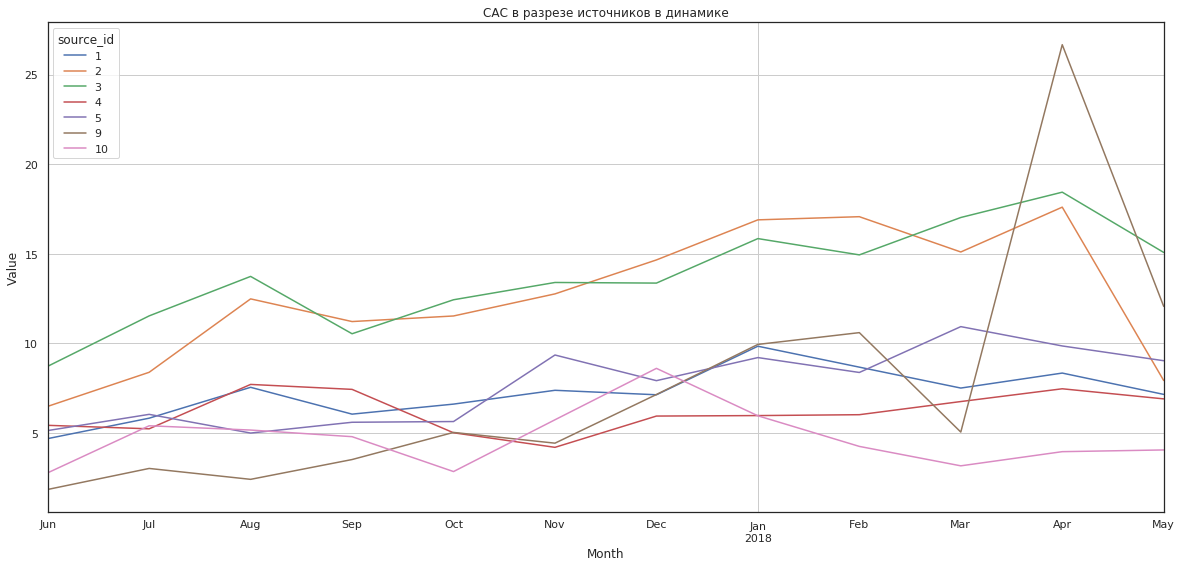

In [119]:
output_cac_source.plot(grid=True, title='CAC в разрезе источников по месяцам', figsize=(20, 9))
pl.title("CAC в разрезе источников в динамике")
pl.xlabel("Month")
pl.ylabel("Value")

На графике видно, что CAC всех источников в целом растет. К апрелю 2018 CAC источника 9 достиг абсолютного максимума – 26.68. Однако к маю 2018 CAC источников 3, 9, 2 существенно снизились.

____________________________________________________________________________________________________________________________

 - <b> ROMI по когортам в разрезе источников.

In [120]:
orders_new['date'] = orders_new['buy_ts'].astype('datetime64[D]')
visits['date'] = visits['end_ts'].astype('datetime64[D]')


In [121]:
buyers = pd.merge(orders_new, visits, on=['date', 'uid'])
buyers['lifetime'] = (buyers['order_month'] - buyers['first_order_month'])/ np.timedelta64(1, 'M')
buyers['lifetime'] = buyers['lifetime'].astype(int)
buyers

,index,buy_ts,revenue,uid,first_order_month,purchase_month,first_order_month_y,order_month,date,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration_sec,first_visit,lifetime
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,120,2017-06-01 00:09:00,0
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,660,2017-06-01 00:14:00,0
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,540,2017-06-01 00:25:00,0
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,1140,2017-06-01 00:14:00,0
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,1680,2017-06-01 07:31:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55053,50408,2018-05-31 23:42:00,0.92,15854392578508828030,2018-05-01,2018-05-01,2018-05-01,2018-05-01,2018-05-31,touch,2018-05-31 23:47:00,4,2018-05-31 23:26:00,2018,5,22,2018-05-31,1260,2018-05-31 23:26:00,0
55054,50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-01,2018-05-01,2018-05-01,2018-05-01,2018-05-31,desktop,2018-05-31 23:02:00,2,2018-05-31 22:35:00,2018,5,22,2018-05-31,1620,2017-12-07 23:20:00,0
55055,50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01,2018-05-01,2018-05-01,2018-05-31,touch,2018-05-31 09:12:00,4,2018-05-31 09:11:00,2018,5,22,2018-05-31,60,2018-05-31 09:11:00,0
55056,50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01,2018-05-01,2018-05-01,2018-05-31,desktop,2018-05-31 23:55:00,10,2018-05-31 23:05:00,2018,5,22,2018-05-31,3000,2018-05-31 23:05:00,0


In [122]:
cohort_sizes = buyers.groupby(['first_order_month','source_id','lifetime']).agg({'uid':'nunique'}).reset_index()
cohort_sizes

,first_order_month,source_id,lifetime,uid
0,2017-06-01,1,0,281
1,2017-06-01,1,2,15
2,2017-06-01,1,3,15
3,2017-06-01,1,4,23
4,2017-06-01,1,5,22
...,...,...,...,...
407,2018-05-01,3,0,665
408,2018-05-01,4,0,694
409,2018-05-01,5,0,547
410,2018-05-01,9,0,39


In [123]:
initial_cohort = cohort_sizes[cohort_sizes['lifetime']==0][['first_order_month','source_id','uid']]
initial_cohort.columns = ['first_order', 'source_id','n_buyers']
initial_cohort.head()

,first_order,source_id,n_buyers
0,2017-06-01,1,281
10,2017-06-01,2,288
20,2017-06-01,3,622
30,2017-06-01,4,410
40,2017-06-01,5,416


In [124]:
#выручка по когортам в разбивке на источники
revenue = buyers.groupby(['first_order_month','source_id','order_month']).agg({'revenue':'sum'}).reset_index()
revenue.columns = ['first_order', 'source_id','order_month','revenue']
revenue.head() 

,first_order,source_id,order_month,revenue
0,2017-06-01,1,2017-06-01,2263.11
1,2017-06-01,1,2017-07-01,288.89
2,2017-06-01,1,2017-08-01,214.59
3,2017-06-01,1,2017-09-01,596.28
4,2017-06-01,1,2017-10-01,776.12


In [125]:
report_new = revenue.merge(initial_cohort, on =['source_id','first_order'])
report_new

,first_order,source_id,order_month,revenue,n_buyers
0,2017-06-01,1,2017-06-01,2263.11,281
1,2017-06-01,1,2017-07-01,288.89,281
2,2017-06-01,1,2017-08-01,214.59,281
3,2017-06-01,1,2017-09-01,596.28,281
4,2017-06-01,1,2017-10-01,776.12,281
...,...,...,...,...,...
500,2018-05-01,3,2018-05-01,2761.96,665
501,2018-05-01,4,2018-05-01,2906.11,694
502,2018-05-01,5,2018-05-01,2659.21,547
503,2018-05-01,9,2018-05-01,136.76,39


In [126]:
costs_1 = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()
costs_1.columns = ['source_id','order_month','costs'] 
costs_1

,source_id,order_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


In [127]:
report_new = report_new.merge(costs_1, on=['source_id', 'order_month'])
report_new

,first_order,source_id,order_month,revenue,n_buyers,costs
0,2017-06-01,1,2017-06-01,2263.11,281,1125.61
1,2017-06-01,1,2017-07-01,288.89,281,1072.88
2,2017-07-01,1,2017-07-01,2716.85,279,1072.88
3,2017-06-01,1,2017-08-01,214.59,281,951.81
4,2017-07-01,1,2017-08-01,275.37,279,951.81
...,...,...,...,...,...,...
499,2017-11-01,10,2018-01-01,1.83,118,614.35
500,2017-12-01,10,2018-01-01,2.44,68,614.35
501,2018-01-01,10,2018-01-01,266.91,83,614.35
502,2017-11-01,10,2017-12-01,7.08,118,645.86


In [128]:
report_new['ltv'] = report_new['revenue'] / report_new['n_buyers']
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi
0,2017-06-01,1,2017-06-01,2263.11,281,1125.61,8.053772,4.005730,2.010563
1,2017-06-01,1,2017-07-01,288.89,281,1072.88,1.028078,3.818078,0.269266
2,2017-07-01,1,2017-07-01,2716.85,279,1072.88,9.737814,3.845448,2.532296
3,2017-06-01,1,2017-08-01,214.59,281,951.81,0.763665,3.387224,0.225455
4,2017-07-01,1,2017-08-01,275.37,279,951.81,0.986989,3.411505,0.289312
...,...,...,...,...,...,...,...,...,...
499,2017-11-01,10,2018-01-01,1.83,118,614.35,0.015508,5.206356,0.002979
500,2017-12-01,10,2018-01-01,2.44,68,614.35,0.035882,9.034559,0.003972
501,2018-01-01,10,2018-01-01,266.91,83,614.35,3.215783,7.401807,0.434459
502,2017-11-01,10,2017-12-01,7.08,118,645.86,0.060000,5.473390,0.010962


In [129]:
report_new['lifetime'] = (report_new['order_month'] - report_new['first_order'])/ np.timedelta64(1, 'M')
report_new['lifetime'] = report_new['lifetime'].astype(int)
report_new

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
0,2017-06-01,1,2017-06-01,2263.11,281,1125.61,8.053772,4.005730,2.010563,0
1,2017-06-01,1,2017-07-01,288.89,281,1072.88,1.028078,3.818078,0.269266,0
2,2017-07-01,1,2017-07-01,2716.85,279,1072.88,9.737814,3.845448,2.532296,0
3,2017-06-01,1,2017-08-01,214.59,281,951.81,0.763665,3.387224,0.225455,2
4,2017-07-01,1,2017-08-01,275.37,279,951.81,0.986989,3.411505,0.289312,1
...,...,...,...,...,...,...,...,...,...,...
499,2017-11-01,10,2018-01-01,1.83,118,614.35,0.015508,5.206356,0.002979,2
500,2017-12-01,10,2018-01-01,2.44,68,614.35,0.035882,9.034559,0.003972,1
501,2018-01-01,10,2018-01-01,266.91,83,614.35,3.215783,7.401807,0.434459,0
502,2017-11-01,10,2017-12-01,7.08,118,645.86,0.060000,5.473390,0.010962,0


<b>Source 1

In [130]:
source_1 = report_new.loc[report_new['source_id'] == 1]
source_1

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
0,2017-06-01,1,2017-06-01,2263.11,281,1125.61,8.053772,4.005730,2.010563,0
1,2017-06-01,1,2017-07-01,288.89,281,1072.88,1.028078,3.818078,0.269266,0
2,2017-07-01,1,2017-07-01,2716.85,279,1072.88,9.737814,3.845448,2.532296,0
3,2017-06-01,1,2017-08-01,214.59,281,951.81,0.763665,3.387224,0.225455,2
4,2017-07-01,1,2017-08-01,275.37,279,951.81,0.986989,3.411505,0.289312,1
...,...,...,...,...,...,...,...,...,...,...
73,2018-01-01,1,2018-05-01,102.13,421,1467.61,0.242589,3.486010,0.069589,3
74,2018-02-01,1,2018-05-01,49.55,447,1467.61,0.110850,3.283244,0.033762,2
75,2018-03-01,1,2018-05-01,770.51,469,1467.61,1.642878,3.129232,0.525010,2
76,2018-04-01,1,2018-05-01,1538.20,300,1467.61,5.127333,4.892033,1.048099,0


In [131]:
output_1 = source_1.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_1.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-06-01,1.14,,1.37,1.76,2.1,2.56,3.52,3.71,4.15,4.78,5.04
2017-07-01,2.53,2.82,3.38,3.67,3.72,3.77,3.78,3.87,,3.99,
2017-08-01,1.54,1.74,1.77,1.88,1.9,1.94,2.06,2.37,2.39,,
2017-09-01,0.87,,1.19,,1.43,1.76,1.8,1.89,,,
2017-10-01,1.63,1.84,1.91,1.93,1.99,2.03,2.14,,,,
2017-11-01,1.39,,1.49,1.68,1.68,2.21,,,,,
2017-12-01,1.42,1.53,1.65,1.71,1.75,,,,,,
2018-01-01,1.19,1.52,1.74,1.81,,,,,,,
2018-02-01,0.71,0.76,0.79,,,,,,,,


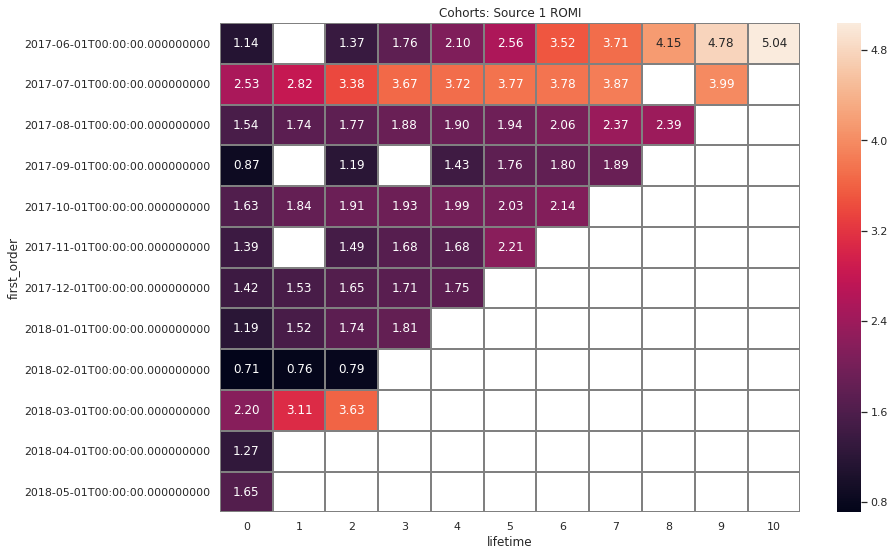

In [132]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 1 ROMI')
sns.heatmap(output_1.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Практически все покупатели,пришедшие с 1 источника, окупаются в первый месяц. Многие не возвращаются в следующий после первой покупки месяц, но в дальнейшем окупаются на 2 и 3 месяц. Больше всего окупились когорты 01.06.2017, 01.07.2017 и 01.03.2018 – расходы на их привлечение окупились от 3,6 до 5 раз. Поскольку продолжительности жизни клиентов, начавшие покупки с 01.03.2018, составляет всего 3 месяца, можно ожидать, что со временем они принесут еще больше прибыли.

<b>Source 2

In [133]:
source_2 = report_new.loc[report_new['source_id'] == 2]
source_2

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
78,2017-06-01,2,2017-06-01,2411.73,288,2427.38,8.374063,8.428403,0.993553,0
79,2017-06-01,2,2017-07-01,274.57,288,2333.11,0.953368,8.101076,0.117684,0
80,2017-07-01,2,2017-07-01,2406.04,246,2333.11,9.780650,9.484187,1.031259,0
81,2017-06-01,2,2017-08-01,521.87,288,1811.05,1.812049,6.288368,0.288159,2
82,2017-07-01,2,2017-08-01,40.33,246,1811.05,0.163943,7.361992,0.022269,1
...,...,...,...,...,...,...,...,...,...,...
151,2018-01-01,2,2018-05-01,62.10,331,2689.44,0.187613,8.125196,0.023090,3
152,2018-02-01,2,2018-05-01,88.72,378,2689.44,0.234709,7.114921,0.032988,2
153,2018-03-01,2,2018-05-01,578.73,388,2689.44,1.491572,6.931546,0.215186,2
154,2018-04-01,2,2018-05-01,326.52,255,2689.44,1.280471,10.546824,0.121408,0


In [134]:
output_2 = source_2.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_2.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-06-01,0.56,,0.84,1.16,1.34,1.42,1.6,1.76,1.86,2.02,2.04
2017-07-01,1.03,1.05,1.12,1.15,1.16,1.17,1.17,1.18,,1.19,
2017-08-01,0.43,0.48,0.51,0.54,0.56,0.57,0.59,0.61,0.64,,
2017-09-01,0.59,,1.78,,1.92,2.23,2.36,2.41,,,
2017-10-01,0.85,1.06,1.11,1.19,1.21,1.22,1.29,,,,
2017-11-01,0.46,,0.54,0.58,0.59,0.6,,,,,
2017-12-01,1.08,1.31,1.81,1.85,1.91,,,,,,
2018-01-01,0.43,0.52,0.55,0.58,,,,,,,
2018-02-01,0.21,0.24,0.27,,,,,,,,


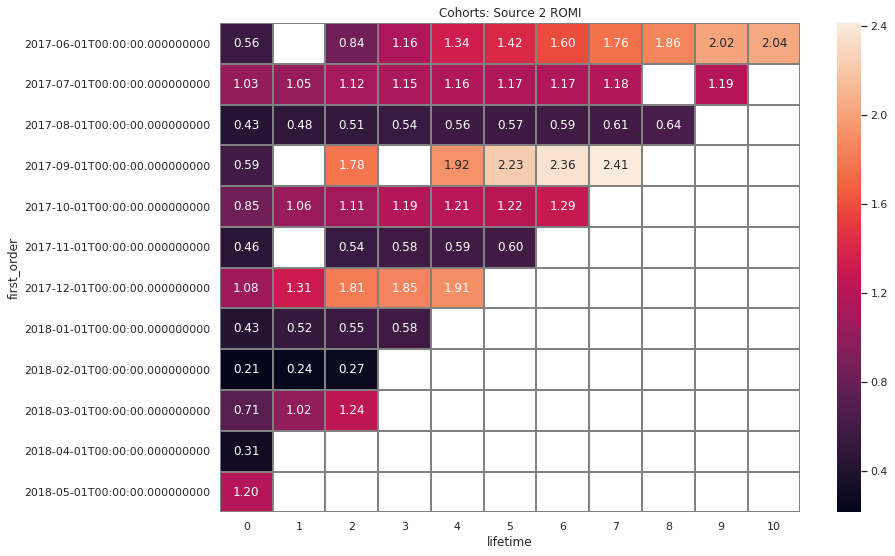

In [135]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 2 ROMI')
sns.heatmap(output_2.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Практически все покупатели,пришедшие со 2 источника, окупаются в среднем c 1 по 4 месяц пользования сервисом. Покупатели, совершившие заказы с августа 2017, ноября 2017, января 2018, февраля 2018 и апреля 2018 так и не окупились. Максимально окупилась когорты 01.06.2017 и 01.09.2017 – они принесли в 2 раза больше, чем было потрачено на их привлечение.

<b>Source 3

In [136]:
source_3 = report_new.loc[report_new['source_id'] == 3]
source_3

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
156,2017-06-01,3,2017-06-01,2567.18,622,7731.65,4.127299,12.430305,0.332035,0
157,2017-06-01,3,2017-07-01,62.80,622,7674.37,0.100965,12.338215,0.008183,0
158,2017-07-01,3,2017-07-01,2316.86,430,7674.37,5.388047,17.847372,0.301896,0
159,2017-06-01,3,2017-08-01,54.04,622,6143.54,0.086881,9.877074,0.008796,2
160,2017-07-01,3,2017-08-01,33.48,430,6143.54,0.077860,14.287302,0.005450,1
...,...,...,...,...,...,...,...,...,...,...
229,2018-01-01,3,2018-05-01,20.90,801,9411.42,0.026092,11.749588,0.002221,3
230,2018-02-01,3,2018-05-01,19.91,907,9411.42,0.021951,10.376428,0.002116,2
231,2018-03-01,3,2018-05-01,119.54,785,9411.42,0.152280,11.989070,0.012702,2
232,2018-04-01,3,2018-05-01,71.48,486,9411.42,0.147078,19.365062,0.007595,0


In [137]:
output_3 = source_3.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_3.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-06-01,0.17,,0.18,0.18,0.18,0.18,0.18,0.19,0.19,0.19,0.19
2017-07-01,0.30,0.31,0.32,0.32,0.32,0.34,0.34,0.35,,0.35,
2017-08-01,0.25,0.26,0.26,0.26,0.27,0.27,0.27,0.27,0.27,,
2017-09-01,0.17,,0.19,,0.19,0.2,0.2,0.2,,,
2017-10-01,0.27,0.28,0.28,0.29,0.29,0.29,0.3,,,,
2017-11-01,0.15,,0.16,0.17,0.17,0.17,,,,,
2017-12-01,0.28,0.29,0.29,0.29,0.29,,,,,,
2018-01-01,0.21,0.22,0.22,0.22,,,,,,,
2018-02-01,0.13,0.13,0.13,,,,,,,,


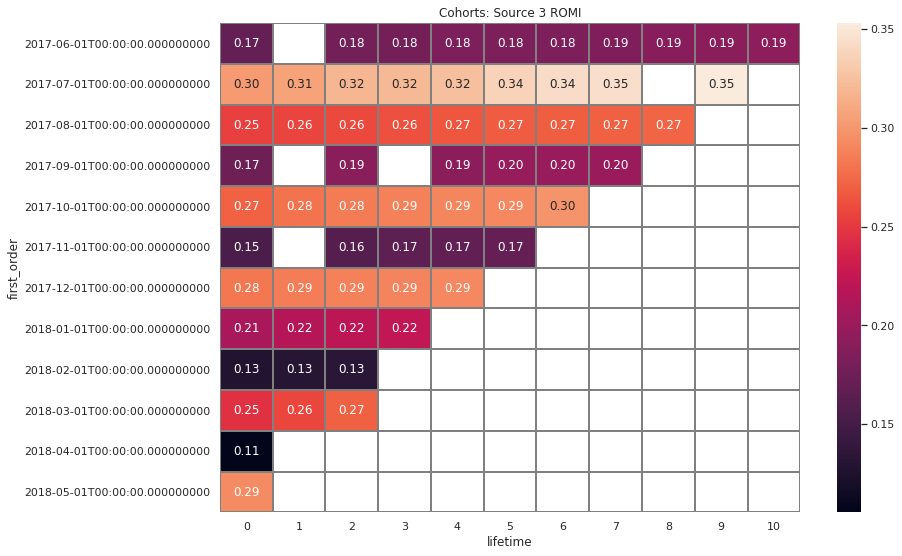

In [138]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 3 ROMI')
sns.heatmap(output_3.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Расходы на привлечение покупателей с 3 источника вообще не окупились. Имеет смысл отказаться от привлечения клиентов по этому источнику.

<b>Source 4

In [139]:
source_4 = report_new.loc[report_new['source_id'] == 4]
source_4

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
234,2017-06-01,4,2017-06-01,1866.33,410,3514.80,4.552024,8.572683,0.530992,0
235,2017-06-01,4,2017-07-01,78.76,410,3529.73,0.192098,8.609098,0.022313,0
236,2017-07-01,4,2017-07-01,2741.99,477,3529.73,5.748407,7.399853,0.776827,0
237,2017-06-01,4,2017-08-01,83.22,410,3217.36,0.202976,7.847220,0.025866,2
238,2017-07-01,4,2017-08-01,52.46,477,3217.36,0.109979,6.744990,0.016305,1
...,...,...,...,...,...,...,...,...,...,...
307,2018-01-01,4,2018-05-01,12.15,915,4214.21,0.013279,4.605694,0.002883,3
308,2018-02-01,4,2018-05-01,13.62,965,4214.21,0.014114,4.367057,0.003232,2
309,2018-03-01,4,2018-05-01,69.60,937,4214.21,0.074280,4.497556,0.016516,2
310,2018-04-01,4,2018-05-01,67.19,621,4214.21,0.108196,6.786167,0.015944,0


In [140]:
output_4 = source_4.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_4.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-06-01,0.28,,0.3,0.32,0.36,0.4,0.43,0.44,0.45,0.48,0.49
2017-07-01,0.78,0.79,0.81,0.83,0.85,0.85,0.86,0.86,,0.87,
2017-08-01,0.55,0.55,0.56,0.57,0.58,0.58,0.58,0.59,0.59,,
2017-09-01,0.23,,0.26,,0.31,0.32,0.32,0.33,,,
2017-10-01,0.83,0.88,0.88,0.9,0.91,0.92,0.93,,,,
2017-11-01,0.52,,0.54,0.57,0.58,0.58,,,,,
2017-12-01,0.66,0.69,0.7,0.71,0.72,,,,,,
2018-01-01,0.66,0.7,0.7,0.71,,,,,,,
2018-02-01,0.36,0.36,0.37,,,,,,,,


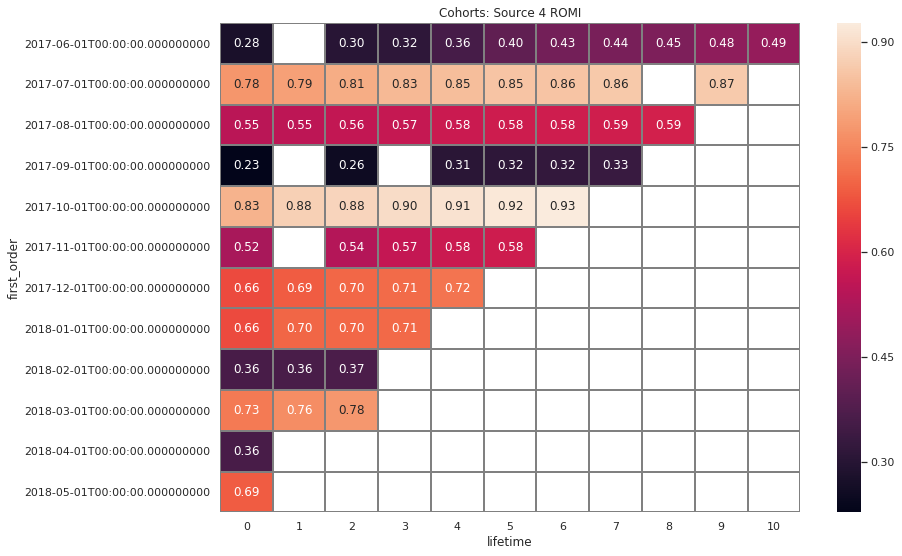

In [141]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 4 ROMI')
sns.heatmap(output_4.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Расходы на привлечение покупателей с 4 источника также не окупились. Возможно расходы на них окупятся через год после первой покупки, поэтому стоит отказаться от привлечения клиентов через этот источник.

<b>Source 5

In [142]:
source_5 = report_new.loc[report_new['source_id'] == 5]
source_5

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
312,2017-06-01,5,2017-06-01,2308.73,416,2616.12,5.549832,6.288750,0.882502,0
313,2017-06-01,5,2017-07-01,277.71,416,2998.14,0.667572,7.207067,0.092627,0
314,2017-07-01,5,2017-07-01,2588.15,436,2998.14,5.936124,6.876468,0.863252,0
315,2017-06-01,5,2017-08-01,190.70,416,2185.28,0.458413,5.253077,0.087266,2
316,2017-07-01,5,2017-08-01,173.84,436,2185.28,0.398716,5.012110,0.079550,1
...,...,...,...,...,...,...,...,...,...,...
385,2018-01-01,5,2018-05-01,147.50,636,3669.56,0.231918,5.769748,0.040196,3
386,2018-02-01,5,2018-05-01,105.12,694,3669.56,0.151470,5.287550,0.028646,2
387,2018-03-01,5,2018-05-01,622.37,595,3669.56,1.046000,6.167328,0.169603,2
388,2018-04-01,5,2018-05-01,364.56,460,3669.56,0.792522,7.977304,0.099347,0


In [143]:
output_5 = source_5.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_5.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_order,,,,,,,,,,,
2017-06-01,0.49,,0.57,0.83,0.95,1,1.09,1.14,1.2,1.22,1.25
2017-07-01,0.86,0.94,0.99,1,1,1.01,1.01,1.02,,1.02,
2017-08-01,0.90,1.01,1.04,1.08,1.14,1.17,1.2,1.2,1.22,,
2017-09-01,1.08,,1.11,,1.12,1.15,1.16,1.19,,,
2017-10-01,0.97,0.98,0.99,1.01,1.04,1.07,1.1,,,,
2017-11-01,0.31,,0.33,0.41,0.41,0.42,,,,,
2017-12-01,0.70,0.74,0.9,0.91,0.94,,,,,,
2018-01-01,0.56,0.62,0.68,0.72,,,,,,,
2018-02-01,0.34,0.37,0.4,,,,,,,,


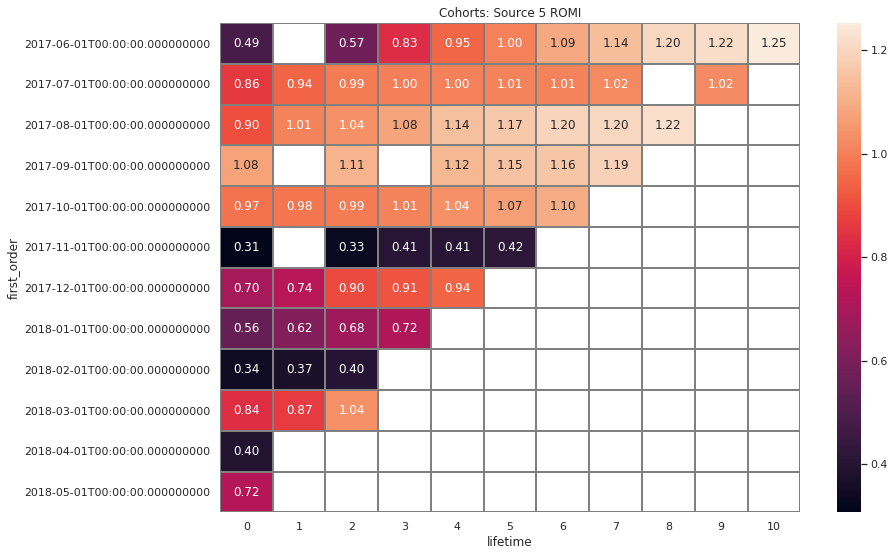

In [144]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 5 ROMI')
sns.heatmap(output_5.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Когорты, пришедшие с 5 источника, окупаются в среднем к 6 месяцу покупок. 

<b>Source 9

In [145]:
source_9 = report_new.loc[report_new['source_id'] == 9]
source_9

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
390,2017-06-01,9,2017-06-01,176.26,53,285.22,3.325660,5.381509,0.617979,0
391,2017-06-01,9,2017-08-01,14.67,53,248.93,0.276792,4.696792,0.058932,2
392,2017-07-01,9,2017-08-01,22.09,52,248.93,0.424808,4.787115,0.088740,1
393,2017-08-01,9,2017-08-01,156.93,46,248.93,3.411522,5.411522,0.630418,0
394,2017-06-01,9,2017-09-01,6.38,53,415.62,0.120377,7.841887,0.015351,3
...,...,...,...,...,...,...,...,...,...,...
477,2018-01-01,9,2018-05-01,0.97,54,362.17,0.017963,6.706852,0.002678,3
478,2018-02-01,9,2018-05-01,2.69,62,362.17,0.043387,5.841452,0.007427,2
479,2018-03-01,9,2018-05-01,2.75,142,362.17,0.019366,2.550493,0.007593,2
480,2018-04-01,9,2018-05-01,3.67,15,362.17,0.244667,24.144667,0.010133,0


In [146]:
output_9 = source_9.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_9.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9
first_order,,,,,,,,,,
2017-06-01,0.62,,0.68,0.69,0.7,0.72,0.73,0.74,0.78,1.06
2017-07-01,0.89,0.98,1.07,1.08,1.09,1.09,1.12,1.12,,1.13
2017-08-01,0.63,0.65,0.66,0.69,0.69,0.7,0.78,0.8,0.83,
2017-09-01,0.31,,0.33,,0.33,0.34,0.34,,,
2017-10-01,0.58,0.63,0.66,0.69,0.71,0.71,0.72,,,
2017-11-01,0.32,,0.33,0.36,,0.39,,,,
2017-12-01,0.46,0.49,0.53,0.62,0.68,,,,,
2018-01-01,0.28,0.3,0.31,0.31,,,,,,
2018-02-01,0.30,0.3,0.31,,,,,,,


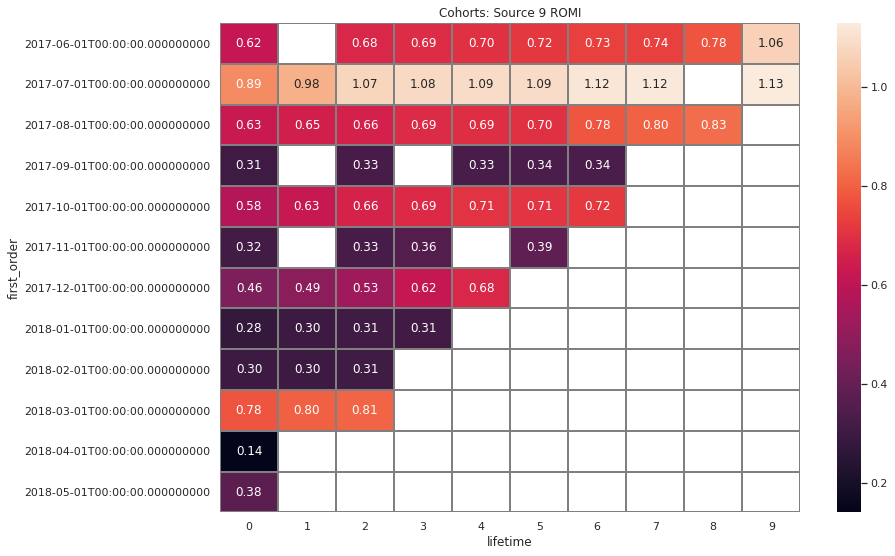

In [147]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 9 ROMI')
sns.heatmap(output_9.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Затраты на покупателей, пришедших с 9 источника, окупились в среднем на 10 месяц пользования. Затраты на покупателей, совершивших первую покупку в июле 2017, окупились на 3 месяц пользования. 

<b>Source 10

In [148]:
source_10 = report_new.loc[report_new['source_id'] == 10]
source_10.head()

,first_order,source_id,order_month,revenue,n_buyers,costs,ltv,cac,romi,lifetime
451,2017-06-01,10,2017-06-01,238.38,95,314.22,2.509263,3.307579,0.758640,0
452,2017-06-01,10,2017-07-01,26.89,95,329.82,0.283053,3.471789,0.081529,0
453,2017-07-01,10,2017-07-01,130.97,49,329.82,2.672857,6.731020,0.397095,0
454,2017-06-01,10,2017-11-01,17.78,95,792.36,0.187158,8.340632,0.022439,5
455,2017-09-01,10,2017-11-01,3.48,74,792.36,0.047027,10.707568,0.004392,2


In [149]:
output_10 = source_10.pivot_table(
    index='first_order', columns='lifetime', values='romi', aggfunc='mean'
)
output_10.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,10
first_order,,,,,,,,,,
2017-06-01,0.42,,,,,0.44,,,0.45,0.46
2017-07-01,0.40,,,,,,,0.42,,
2017-08-01,1.46,1.49,1.5,,,,1.51,,,
2017-09-01,0.35,,0.35,,,0.36,0.36,0.37,,
2017-10-01,0.89,0.89,,0.9,0.94,,,,,
2017-11-01,0.35,,0.35,0.36,0.37,0.37,,,,
2017-12-01,0.40,0.4,0.41,0.42,,,,,,
2018-01-01,0.43,0.45,0.45,,,,,,,
2018-02-01,0.33,,,,,,,,,


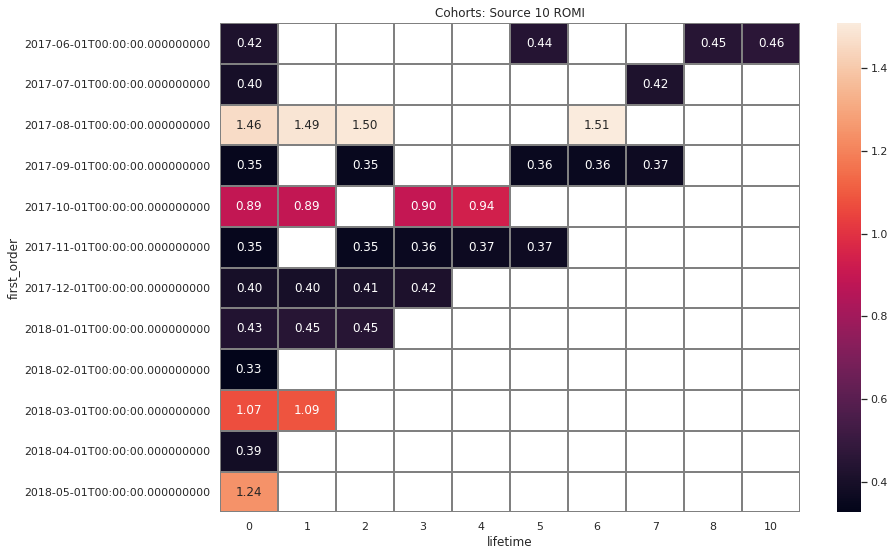

In [150]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Source 10 ROMI')
sns.heatmap(output_10.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Затраты на источник 10 окупились только у покупателей, совершивших первую покупку в августе 2017, марте 2018 и мае 2018. Для этого потребовалось от 1 до 7 месяцев. В общем по этому источнику затраты не окупились.

## Выводы

По каждому источнику трафика были расчитаны стоимость привлечения клиента (CAC), «пожизненная» ценность клиента (LTV) и окупаемость (ROMI).

- Источник 1: практически все покупатели,пришедшие с 1 источника, окупаются в первый месяц. Многие не возвращаются в следующий после первой покупки месяц, но в дальнейшем окупаются на 2 и 3 месяц. Больше всего окупились когорты 01.06.2017, 01.07.2017 и 01.03.2018 – расходы на их привлечение окупились от 3,6 до 5 раз. Стоимость привлечения клиента у этого источника – 7,19 у.е.

- Источник 2: практически все покупатели,пришедшие со 2 источника, окупаются в среднем c 1 по 4 месяц пользования сервисом. Покупатели, совершившие заказы с августа 2017, ноября 2017, января 2018, февраля 2018 и апреля 2018 так и не окупились. Максимально окупилась когорты 01.06.2017 и 01.09.2017 – они принесли в 2 раза больше, чем было потрачено на их привлечение. Стоимость привлечения клиента у источника 2 одна из самых высоких – 12,21 у.е.

- Источник 3: расходы на привлечение покупателей с 3 источника вообще не окупились, при том, что стоимость привлечения клиента самая высокая среди остальных источников – 13,49 у.е. Несмотря на то, что с 3 источника приходит больше всего посетителей, имеет смысл отказаться от привлечения клиентов по этому источнику и направить усилия и средства на продвижение через другой источник.

- Источник 4: расходы на привлечение покупателей с 4 источника также не окупились, стоимость привлечения клиента – 5,93 у.е. Расходы на них могут окупиться через год после первой покупки. Возможно поэтому стоит отказаться от привлечения клиентов и через этот источник.

- Источник 5: Когорты, пришедшие с 5 источника, окупаются в среднем к 6 месяцу покупок. Однако их стоимость привлечения клиента высока – 7,47 у.е. 

- Источники 6 и 7: в датафрейме, содержащем данные о расходов на маркетинг, отсутствуют затраты по источникам 6 и 7. Значит клиенты привлекались без сторонних затрат, например, с помощью размещения информации о продукте на сайтах и площадках партнеров на безвозмездной основе или покупатели переходили на сервис через поисковые сервисы Google или Яндекс. Через источник 7 пришел один покупатель, а источник 6 – ноль. Судя по всему эти каналы привлечения клиентов не работают.

- Источник 9: Затраты на покупателей, пришедших с 9 источника, окупились в среднем на 10 месяц пользования. Несмотря на низкую стоимость привлечения клиентов (5,07 у.е), с этого источника на сайт приходят не так много посетителей. 

- Источник 10: Затраты на источник 10 окупились только у покупателей, совершивших первую покупку в августе 2017, марте 2018 и мае 2018. Для этого потребовалось от 1 до 7 месяцев. В общем по этому источнику затраты не окупились. Средняя стоимость клиента самая низкая – 4,38 у.е., а уникальных посетителей с этого источника пришло немного. Возможно, стоит от от него отказаться.

Маркетологам однозначно стоит сделать больший упор на источнике 1, продолжить работать с источниками 2 и 9, а также оптимизировать 6 и 7, не требуюющих затрат, чтобы привлечь новых клиентов. 

Среднее количество уникальных посетителей сайта Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- в день – 908 человек;
- в неделю – 5 716 человек;
- в месяц – 23 228 человек.

С начала августа 2017 года в целом количество посетителей в неделю расло, достигнув максимума на во второй половине ноября 2017 года. С тех пор количество уникальных посетителей понемногу снижается.

Пользователи в среднем посещают сайт Яндекс.Афиши 987 раз в день. В среднем посетители находятся на сайте в среднем 60 секунд, именно столько же требуется на покупку. Значит посетители приходят на сайт за конкретным продуктом, который уже выбрали, и сразу же его приобретают без лишних размышлений. Учитывая среднюю продолжительность сеанса, посетители не заходят на сайт для выбора, чем бы заняться в ближайшее время.

Очень низкое значение возвращаемости клиентов. Средний процент возвращаемости на 2 месяц жизни когорт – 6,52%. Стоит построить воронку продаж и проверить, в какой момент клиент уходит, чтобы понять, что именно ему не понравилось, а также исследовать свою целевую аудиторию, чтобы предлагать им продукты по интересам. 

Те, кто все же приобрел какой-либо продукт, в среднем совершают 1,79 покупки в течение 6 месяцев. 


Большая часть посетителей заходят на сайт с компьютера (desktop) и только 30% – через мобильные телефоны (touch).Согласно исследованию Mediascope в 2020 году, большинство россиян (67%) используют смартфон для выхода в интернет. Для увеличения количества посещений нужно адаптировать сайт под мобильную версию так, чтобы потенциальным покупателям было удобно им пользоваться. Возможно стоит подумать над оптимизацией платежной системы в мобильной версии/приложении, добавить на сайт возможность оплаты через ApplePay и GooglePay, чтобы посетителям было удобнее делать покупки. 


Средний чек составляет 4.99 у.е. В целом средний чек покупателя в каждом последующим месяце растет. Особо выделяются покупатели, совершившие первую покупку в сентябре 2017 года, – через 2 месяца после первой покупки их средний чек составил 52.66 у.е. Видимо в ноябре 2017 им были предложены специальные предложения или скидки. Покупателям, совершившим первую покупку в декабре 2017 года, судя по всему тоже предложили спец. предложения с февраля по апрель 2018 года – их средний чек в этот период составил от 21,16 от 26,85 у.е.


Cредний LTV по когортам за 6 месяцев – 7.97 у.е. Самую большую сумму покупатели тратят в первый месяц пользования с сервисом. Пользователи, совершившие первую покупку в сентябре 2017, принесли больше выручки. На четвертый месяц покупок у этой кагорты есть скачок в LTV. Стоит посмотреть, как привлекли эту когорту на повторную покупку.

Всего на маркетинг потрачено 329 132 у.е., большую часть из которых выделено на источник 3 – 43%, который является одним из самых неэффективных.

Стоимость привлечения клиента (CAC) на одного покупателя в среднем составляет 9.01 у.е. Самые дорогие источники – 3 и 2. Оптимизируя ключевые источники привлечения клиента, со временем CAC уменьшится. 

Однозначно стоит отказаться от источников 3, 4 и 10 и перенаправить бюджет на источники 1 и 2. Стоит рассмотреть работу источников 6 и 7, не требующих затрат, чтобы привлекать новых покупателей. 

Самыми перспективными когортами клиентов являются те, кто пришел с 1 источника и совершил покупку в июне 2017, июле 2017 и марте 2018.